# Hands-on 1: Tutorial del Clasificador Perceptrón

**Nombre:** Christopher Leonardo Lopez Vilchis
**Fecha:** 04/11/2025

Este notebook sirve como un tutorial para implementar el clasificador Perceptron utilizando Python y la librería `scikit-learn`.

## 1.1 Fundamentos de la técnica

El **Perceptrón** es uno de los algoritmos de aprendizaje supervisado más antiguos y simples, inventado por Frank Rosenblatt en 1957. Es un **clasificador lineal binario**, lo que significa que:
* Toma varias entradas.
* Las combina linealmente.
* Aplica una función de activación.
* Produce una salida única que pertenece a una de dos clases.

El objetivo del Perceptrón es encontrar un **hiperplano** que separe los datos en dos clases. El algoritmo aprende de los datos de entrenamiento ajustando sus "pesos" cada vez que comete un error de clasificación. Solo se garantiza que el Perceptrón converja si los datos son **linealmente separables**.

## 1.2 Modelo Matemático del Perceptrón

El modelo matemático es bastante directo.

1.  **Entrada Neta (z):** Se calcula como la suma ponderada de las características de entrada ($x$) más un término de sesgo ($b$).
    * Dado un vector de entrada: $x = (x_1, x_2, ..., x_n)$
    * Y un vector de pesos: $w = (w_1, w_2, ..., w_n)$
    * La entrada neta $z$ es:
        $$z = w \cdot x + b = \sum_{i=1}^{n} w_i x_i + b$$

2.  **Función de Activación ($\phi$):** Se aplica una función escalón (step function) a $z$ para obtener la predicción ($\hat{y}$).
    * La predicción $\hat{y}$ (la clase predicha) se decide así:
        $$\hat{y} = \phi(z) = \begin{cases} 1 & \text{si } z \ge \theta \\ -1 & \text{si } z < \theta \end{cases}

    * (En `scikit-learn`, el umbral $\theta$ suele estar incorporado en el sesgo $b$, por lo que la comparación es simplemente $\text{si } z \ge 0$).

3.  **Regla de Aprendizaje (Actualización de Pesos):** Si el Perceptrón se equivoca ($y \neq \hat{y}$), actualiza los pesos $w$ y el sesgo $b$ para la próxima iteración.
    * $\Delta w_i = \eta (y - \hat{y}) x_i$
    * $\Delta b = \eta (y - \hat{y})$
    * Donde $\eta$ (eta) es la **tasa de aprendizaje** (un número pequeño, ej. 0.1).

## 1.3 Descripción de la librería, clases y funciones

Para esta implementación, usare principalmente la librería **Scikit-learn** (`sklearn`), que es el estándar para Machine Learning en Python.

* `sklearn.linear_model.Perceptron`: Esta es la clase principal que implementa el algoritmo Perceptrón. No tenemos que programar la regla de aprendizaje manualmente; `scikit-learn` se encarga. Sus métodos clave son:
    * `.fit(X, y)`: Entrena el modelo con los datos de entrenamiento (`X`) y las etiquetas (`y`).
    * `.predict(X)`: Realiza predicciones sobre nuevos datos (`X`).
* `sklearn.datasets.load_iris`: Usaremos este conjunto de datos clásico como ejemplo.
* `sklearn.model_selection.train_test_split`: Una función vital para dividir nuestros datos en conjuntos de entrenamiento y prueba, asegurando que podamos evaluar el modelo en datos que no ha "visto" antes.
* `sklearn.metrics.accuracy_score`: La función que usaremos para calcular la métrica de "Accuracy" (Exactitud).
* `numpy`: Librería fundamental para cómputo numérico, `scikit-learn` se basa en ella (ej. para manejar los arrays de datos).
* `matplotlib.pyplot`: La usaremos para visualizar nuestros datos y la línea de decisión que aprende el Perceptrón.

In [8]:
# Celda de importaciones
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

## 1.4 Pipeline de Machine Learning

### + Ingeniería de Características

Vamos a cargar el dataset "Iris". Este dataset tiene 3 clases (Setosa, Versicolor, Virginica) y 4 características (largo y ancho de sépalo y pétalo).

**Descripción de variables a emplear:**

Como el Perceptrón base es un **clasificador binario**, modificaremos el dataset:
1.  **Clases:** Solo usaremos las clases 0 (Setosa) y 1 (Versicolor).
2.  **Características:** Para poder visualizar la frontera de decisión en un gráfico 2D, solo usaremos dos características:
    * 'sepal length (cm)'
    * 'petal length (cm)'

Estas dos características son nuestras **variables (señales) de entrada**. La **variable de salida** es la clase de la flor (0 o 1).

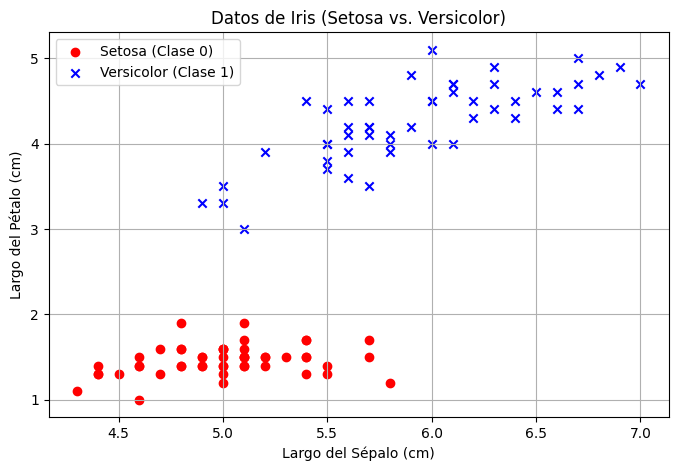

In [9]:
# Cargar datos
iris = load_iris()

# Seleccionamos solo 2 características (Sepal Length y Petal Length) -> X
# Y filtramos para las primeras 2 clases (Setosa y Versicolor) -> y
X = iris.data[:100, [0, 2]]  # Índices 0 (Sepal Length) y 2 (Petal Length)
y = iris.target[:100]        # Clases 0 (Setosa) y 1 (Versicolor)

# Visualicemos los datos que usaremos
plt.figure(figsize=(8, 5))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='o', label='Setosa (Clase 0)')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='x', label='Versicolor (Clase 1)')

plt.xlabel('Largo del Sépalo (cm)')
plt.ylabel('Largo del Pétalo (cm)')
plt.legend(loc='upper left')
plt.title('Datos de Iris (Setosa vs. Versicolor)')
plt.grid(True)
plt.show()

### + Selección del Modelo

**Razones formales para emplear un clasificador lineal:**

Observando la gráfica anterior, **la razón principal para elegir un clasificador lineal es que los datos parecen ser linealmente separables**.

Es decir, visualmente podemos trazar una línea recta que separe casi perfectamente los puntos rojos (Setosa) de los puntos azules (Versicolor). El Perceptrón está diseñado específicamente para encontrar esta línea (o hiperplano en más dimensiones). Si los datos formaran patrones complejos (ej. un círculo dentro de otro), un clasificador lineal simple fracasaría y necesitaríamos métodos más avanzados.

### + Entrenamiento del Modelo

Ahora, dividiremos nuestros datos (`X` e `y`) en dos conjuntos:
1.  **Conjunto de Entrenamiento (Training):** El modelo "verá" estos datos para aprender los pesos.
2.  **Conjunto de Prueba (Test):** El modelo será evaluado en estos datos, que nunca vio durante el entrenamiento, para medir su rendimiento real.

Usaremos `train_test_split` para esto. Luego, crearemos una instancia del `Perceptron` y usaremos el método `.fit()` para entrenarlo.

In [10]:
# 1. Dividir los datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

# 2. Instanciar el modelo
# eta0 es la tasa de aprendizaje (learning rate)
# max_iter es el número máximo de "pasadas" sobre los datos (epochs)
ppn = Perceptron(eta0=0.1, max_iter=100, random_state=1)

# 3. Entrenar el modelo (aquí ocurre la magia de la regla de aprendizaje)
ppn.fit(X_train, y_train)

print("\n¡Modelo entrenado exitosamente!")

Tamaño de X_train: (80, 2)
Tamaño de X_test: (20, 2)

¡Modelo entrenado exitosamente!


### + Predicción

Una vez entrenado, el modelo (`ppn`) tiene los pesos y el sesgo almacenados. Ahora podemos usar el método `.predict()` para clasificar nuevos datos.

Crearemos una función simple para probar patrones de entrada.

In [11]:
def probar_patron(patron):
    """
    Toma un patrón de entrada (largo_sepalo, largo_petalo) y predice su clase.
    """
    # El modelo espera una entrada 2D (un array de patrones)
    # [[largo_sepalo, largo_petalo]]
    patron_array = np.array([patron])

    # Realizar la predicción
    prediccion = ppn.predict(patron_array)

    # Interpretar el resultado
    clase_predicha = "Setosa (Clase 0)" if prediccion[0] == 0 else "Versicolor (Clase 1)"

    print(f"Patrón de entrada: {patron}")
    print(f"Clase predicha: {clase_predicha}")
    return prediccion[0]

# Prueba 1: Un patrón que claramente parece Setosa (Sépalo 5cm, Pétalo 1.5cm)
print("--- Prueba 1 ---")
probar_patron([5.0, 1.5])

# Prueba 2: Un patrón que claramente parece Versicolor (Sépalo 6.5cm, Pétalo 4.5cm)
print("\n--- Prueba 2 ---")
probar_patron([6.5, 4.5])

--- Prueba 1 ---
Patrón de entrada: [5.0, 1.5]
Clase predicha: Setosa (Clase 0)

--- Prueba 2 ---
Patrón de entrada: [6.5, 4.5]
Clase predicha: Versicolor (Clase 1)


np.int64(1)

### + Evaluación del Modelo

El paso final es evaluar qué tan bien funciona nuestro modelo en el **conjunto de prueba** (los datos que reservamos y que el modelo no usó para entrenar).

Usaremos la métrica **Accuracy (Exactitud)**.

**Breve explicación de la Métrica Accuracy:**
La exactitud mide la proporción de predicciones correctas sobre el número total de predicciones realizadas. Es la métrica más simple para evaluación.

$$\text{Accuracy} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}}$$

Un "Accuracy" de 1.0 significa un 100% de aciertos (perfecto). Un 0.8 significa un 80% de aciertos.

In [12]:
# 1. Usar el modelo entrenado para predecir las etiquetas del CONJUNTO DE PRUEBA
y_pred = ppn.predict(X_test)

# 2. Comparar las predicciones (y_pred) con las etiquetas reales (y_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Predicciones del modelo: {y_pred}")
print(f"Etiquetas reales:        {y_test}")
print(f"\nAccuracy (Exactitud) en el conjunto de prueba: {accuracy:.2f}")
print(f"Esto significa que el modelo acertó en el {accuracy * 100}% de los casos.")

Predicciones del modelo: [1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1]
Etiquetas reales:        [1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1]

Accuracy (Exactitud) en el conjunto de prueba: 1.00
Esto significa que el modelo acertó en el 100.0% de los casos.


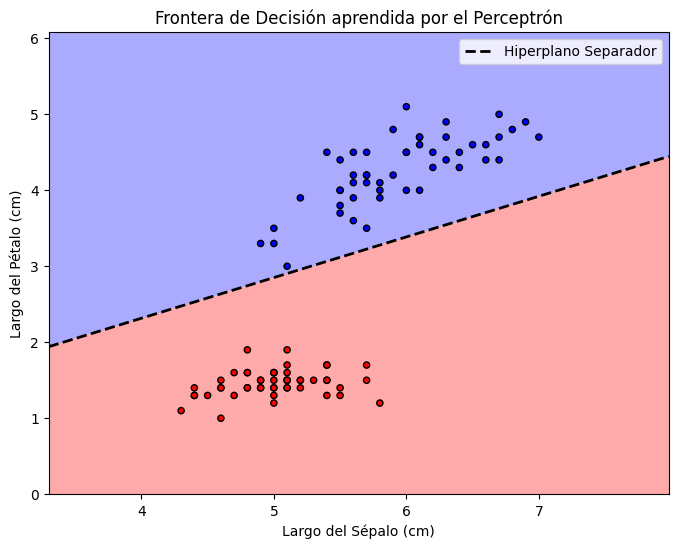

In [13]:
# (Opcional pero muy recomendado)
# --- Visualización de la Frontera de Decisión ---
# Este código crea una gráfica que muestra la línea que el Perceptrón "aprendió"

from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, classifier):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.title("Frontera de Decisión aprendida por el Perceptrón")
    plt.xlabel('Largo del Sépalo (cm)')
    plt.ylabel('Largo del Pétalo (cm)')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Muestra la línea (hiperplano)
    w = classifier.coef_[0]
    b = classifier.intercept_[0]
    line_x = np.array([xx.min(), xx.max()])
    line_y = -(w[0] * line_x + b) / w[1]
    plt.plot(line_x, line_y, 'k--', lw=2, label='Hiperplano Separador')

    plt.legend()
    plt.show()

# Graficar la frontera usando todos los datos (X, y) para una mejor visualización
plot_decision_boundary(X, y, ppn)

## 2. Verificación de Ejecución

Este notebook ha sido creado con celdas de texto y celdas de código ordenadas secuencialmente. Para ejecutarlo en Google Colab:

1.  Asegúrate de tener un entorno de Python 3.
2.  Si usas Colab, las librerías (`numpy`, `sklearn`, `matplotlib`) ya vienen instaladas.
3.  Ejecuta las celdas en orden, desde la primera ("Celda de importaciones") hasta la última.

## 3. Referencias bibliográficas

* Documentación oficial de Scikit-learn:
    * (Perceptron): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html
    * (train_test_split): https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    * (accuracy_score): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
* Raschka, S., & Mirjalili, V. (2019). *Python Machine Learning* (3rd ed.). Packt Publishing. (Capítulo 2 trata sobre el Perceptrón).
* Rosenblatt, F. (1957). *The Perceptron: A Perceiving and Recognizing Automaton*. Cornell Aeronautical Laboratory.